# Rechenberg in Python
Trying to answer the question: #Q how often are your mutations actually helping (indirect feedback: since you never need to know where the optimum is or how far you are from it, since the success rate tells you whether your current σ is well calibrated, and you adjust accordingly)? 
what success rate is theoretically optimal for a (1+1)-ES on a sphere function? He derived mathematically that the answer is 1/5.

* If more than 1 in 5 mutations succeed → sigma is too small, you're being too cautious → increase it
* If fewer than 1 in 5 succeed → sigma is too large, most jumps are landing in worse territory → decrease it

Every k =10 generations, count how many if the last 10 children were better than their parent (the success rate). Then: 

success rate > 1/5  →  sigma is too small  →  multiply by τ  (jump further)
success rate < 1/5  →  sigma is too large  →  divide by τ    (jump smaller)

The magic number 1/5 comes from Rechenberg's theory — it's empirically the optimal success rate for sphere-like functions.

τ is the scale factor, it controls how aggressive the adaptation is (meaning it controls the speed of adaptation)
τ=1.1 — tiny adjustments, sigma barely changes → slow convergence
τ=1.5 — moderate, good balance
τ=2.0 — aggressive, sigma shrinks fast near the optimum → best final precision
Fixed σ=0.5 — no adaptation at all → worst result by 10+ orders of magnitude


Self Adaptation:
don't write a rule for updating σ at all. Instead, make σ part of the solution itself and let the algorithm evolve it.
σ mutates (log-normally, so it stays positive) and then gets used to mutate x. If a particular σ value produces good offspring, those offspring survive and carry that σ forward. If it produces bad offspring, they die.
The insight is: individuals with well-tuned σ will naturally outcompete those with poorly-tuned σ. You don't need to write the adaptation rule — selection pressure does it for you. This works, but it's noisy. σ is evolving on the same timescale as x, which isn't always ideal.


#Q Why is n=10 so much harder than n=2? 
It’s the curse of dimensionality -> the volume of space grows exponentially with dimensions. In 2D, if you step randomly, there are only so many directions you can go wrong. In 10D, a random Gaussian vector points in 10 dimensions simultaneously — the chance that all 10 components happen to move you closer to [0,0,...,0] drops dramatically with each added dimension.



In [1]:
pip install cma -q


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cma

# ----- Benchmark functions -----

def sphere(x):
    return np.sum(x**2)

def rastrigin(x):
    x = np.array(x)
    return 10*len(x) + np.sum(x**2 - 10*np.cos(2*np.pi*x))

In [3]:
def one_plus_one_es_classic(fitness_function, N=10, sigma=0.5, max_generations=1000):
    x = np.random.uniform(-5, 5, N)
    history = []

    for _ in range(max_generations):
        x_prime = x + sigma * np.random.normal(0, 1, N)
        print(fitness_function(x))
        if fitness_function(x_prime) <= fitness_function(x):
            x = x_prime
        history.append(fitness_function(x))
        sigma*=0.99

    return x, history


for f in [sphere]:
    x_best, history = one_plus_one_es_classic(f)
    print(f.__name__, "Best fitness:", history[-1])

94.3519055730138
94.3519055730138
94.3519055730138
88.16237559492421
80.74962386117093
66.77710802032651
66.77710802032651
64.26543880360147
64.26543880360147
64.26543880360147
62.45475085265235
62.45475085265235
62.45475085265235
62.45475085265235
62.45475085265235
52.22848901972364
52.22848901972364
52.22848901972364
44.16673937095453
44.16673937095453
41.38085651215243
41.38085651215243
41.38085651215243
41.38085651215243
40.485314604095684
40.485314604095684
40.485314604095684
37.006673513892444
37.006673513892444
36.89487802720318
36.89487802720318
33.25057267533807
32.09588366154002
32.09588366154002
32.09588366154002
32.09588366154002
32.09588366154002
30.803491318180125
30.803491318180125
28.92238030467536
28.92238030467536
28.92238030467536
25.691150879055353
25.691150879055353
25.691150879055353
23.21444443423171
22.33231799346373
22.33231799346373
21.900894982513037
19.075962916519934
19.075962916519934
19.075962916519934
15.916324733979204
15.916324733979204
15.916324733979

In [4]:
def one_plus_one_es_success_rule(fitness_function, N=10, sigma=0.5, max_generations=2000):
    x = np.random.uniform(-5, 5, N)
    tau = 1.5
    k = 20
    success_count = 0
    history = []

    for t in range(1, max_generations + 1):
        x_prime = x + sigma * np.random.normal(0, 1, N)
        if fitness_function(x_prime) <= fitness_function(x):
            x = x_prime
            success_count += 1

        if t % k == 0:
            success_rate = success_count / k
            if success_rate > 1/5:
                sigma *= tau
            else:
                sigma /= tau
            success_count = 0

        history.append(fitness_function(x))

    return x, history


for f in [sphere, rastrigin]:
    x_best, history = one_plus_one_es_success_rule(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 4.894915344199461e-24
rastrigin Best fitness: 69.64683086177214


In [5]:
def mu_plus_lambda_es(fitness_fn, dim=10, mu=5, lmbda=20, generations=200, sigma=0.3):
    population = np.random.randn(mu, dim)
    history = []

    for _ in range(generations):
        offspring = []
        for _ in range(lmbda):
            parent = population[np.random.randint(mu)]
            child = parent + sigma * np.random.randn(dim)
            offspring.append(child)

        combined = np.vstack([population, offspring])
        fitness = np.array([fitness_fn(ind) for ind in combined])
        best_indices = np.argsort(fitness)[:mu]
        population = combined[best_indices]
        history.append(fitness[best_indices[0]])

    return population[0], history


for f in [sphere, rastrigin]:
    best, history = mu_plus_lambda_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 0.06535677758982496
rastrigin Best fitness: 28.20304080123313


In [6]:
def self_adaptive_es(fitness_fn, dim=10, mu=5, lmbda=20, generations=200):
    tau = 1 / np.sqrt(dim)
    population = [(np.random.randn(dim), 0.5) for _ in range(mu)]
    history = []

    for _ in range(generations):
        offspring = []
        for _ in range(lmbda):
            x, sigma = population[np.random.randint(mu)]
            sigma_prime = sigma * np.exp(tau * np.random.randn())
            sigma_prime = max(sigma_prime, 1e-8)
            x_prime = x + sigma_prime * np.random.randn(dim)
            offspring.append((x_prime, sigma_prime))

        combined = population + offspring
        fitness = [fitness_fn(ind[0]) for ind in combined]
        best_indices = np.argsort(fitness)[:mu]
        population = [combined[i] for i in best_indices]
        history.append(fitness[best_indices[0]])

    return population[0], history


for f in [sphere, rastrigin]:
    best, history = self_adaptive_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 7.419062624655615e-14
rastrigin Best fitness: 5.969754342559909


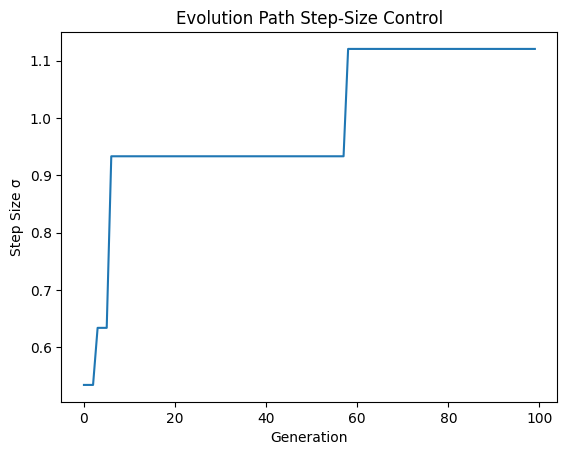

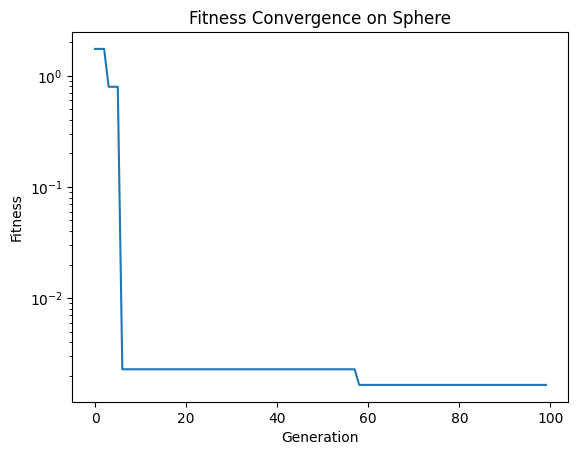

In [7]:
def evolution_path_es(generations=100):
    x = 2.0
    sigma = 0.5
    p_sigma = 0.0
    c_sigma = 0.3
    d_sigma = 1.0
    expected_norm = np.sqrt(2/np.pi)

    sigma_vals = []
    fitness_vals = []

    for _ in range(generations):
        z = np.random.randn()
        x_candidate = x + sigma * z

        # Elitist selection
        if sphere(x_candidate) < sphere(x):
            x = x_candidate
            p_sigma = (1 - c_sigma) * p_sigma + np.sqrt(c_sigma*(2-c_sigma)) * z
            sigma *= np.exp((c_sigma/d_sigma) * (abs(p_sigma)/expected_norm - 1))

        sigma_vals.append(sigma)
        fitness_vals.append(sphere(x))

    return sigma_vals, fitness_vals

sigma_vals, fitness_vals = evolution_path_es()

# Plot step size
plt.figure()
plt.plot(sigma_vals)
plt.xlabel("Generation")
plt.ylabel("Step Size σ")
plt.title("Evolution Path Step-Size Control")
plt.show()

# Plot fitness (log scale)
plt.figure()
plt.plot(fitness_vals)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.yscale("log")
plt.title("Fitness Convergence on Sphere")
plt.show()

In [8]:
def simple_cma_es(fitness_fn, N=10, sigma=0.5, lambda_=10, mu=5, generations=200):
    x = np.random.randn(N)
    C = np.eye(N)
    history = []

    for _ in range(generations):
        A = np.linalg.cholesky(C)
        Z = np.random.randn(lambda_, N)
        X = x + sigma * Z @ A.T
        fitnesses = np.array([fitness_fn(xi) for xi in X])
        indices = np.argsort(fitnesses)
        selected = X[indices[:mu]]
        x_mean = np.mean(selected, axis=0)

        C_update = np.zeros((N,N))
        for xi in selected:
            diff = xi - x_mean
            C_update += np.outer(diff, diff)
        C = 0.8*C + 0.2*(C_update/mu)

        if fitness_fn(x_mean) <= fitness_fn(x):
            x = x_mean

        history.append(fitness_fn(x))

    return x, history


for f in [sphere, rastrigin]:
    best, history = simple_cma_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 0.0020666088248251072
rastrigin Best fitness: 21.889053878327516


In [9]:
def run_pycma(fitness_fn):
    N = 10
    initial_mean = np.random.randn(N)
    initial_sigma = 0.5

    es = cma.CMAEvolutionStrategy(initial_mean, initial_sigma)
    es.optimize(fitness_fn, maxfun=10000)
    print("Best fitness:", es.result.fbest)

print("Sphere:")
run_pycma(sphere)

print("\nRastrigin:")
run_pycma(rastrigin)

Sphere:
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1050013, Tue Feb 24 09:34:10 2026)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]


    1     10 1.782780084856150e+01 1.0e+00 4.86e-01  5e-01  5e-01 0:00.0
    2     20 1.511182300500425e+01 1.2e+00 4.91e-01  5e-01  5e-01 0:00.0
    3     30 1.223035914056952e+01 1.4e+00 4.95e-01  5e-01  5e-01 0:00.0
  100   1000 7.619394479051734e-06 1.9e+00 2.41e-03  9e-04  1e-03 0:00.1
  200   2000 1.813013383820706e-12 1.8e+00 2.59e-06  4e-07  5e-07 0:00.1
  229   2290 2.995770844453813e-14 1.8e+00 4.16e-07  5e-08  7e-08 0:00.1
termination on {'tolfun': 1e-11}
final/bestever f-value = 2.995771e-14 2.643990e-14 after 2290/2251 evaluations
incumbent solution: [-3.46102692e-08  3.88292616e-08  2.93427111e-08  7.20708684e-08
  3.71549272e-08 -3.47285402e-08  9.63930188e-08  1.72986621e-08 ...]
std deviations: [6.09931008e-08 5.63354678e-08 5.82442839e-08 5.29497763e-08
 6.50262372e-08 5.55865217e-08 6.23787967e-08 6.27813522e-08 ...]
Best fitness: 2.6439896069121133e-14

Rastrigin:
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1038964, Tue Feb 24 09:34:11 2026)
Iterat #Fe

# EXERCISES 3(a)(b)(c)(d)

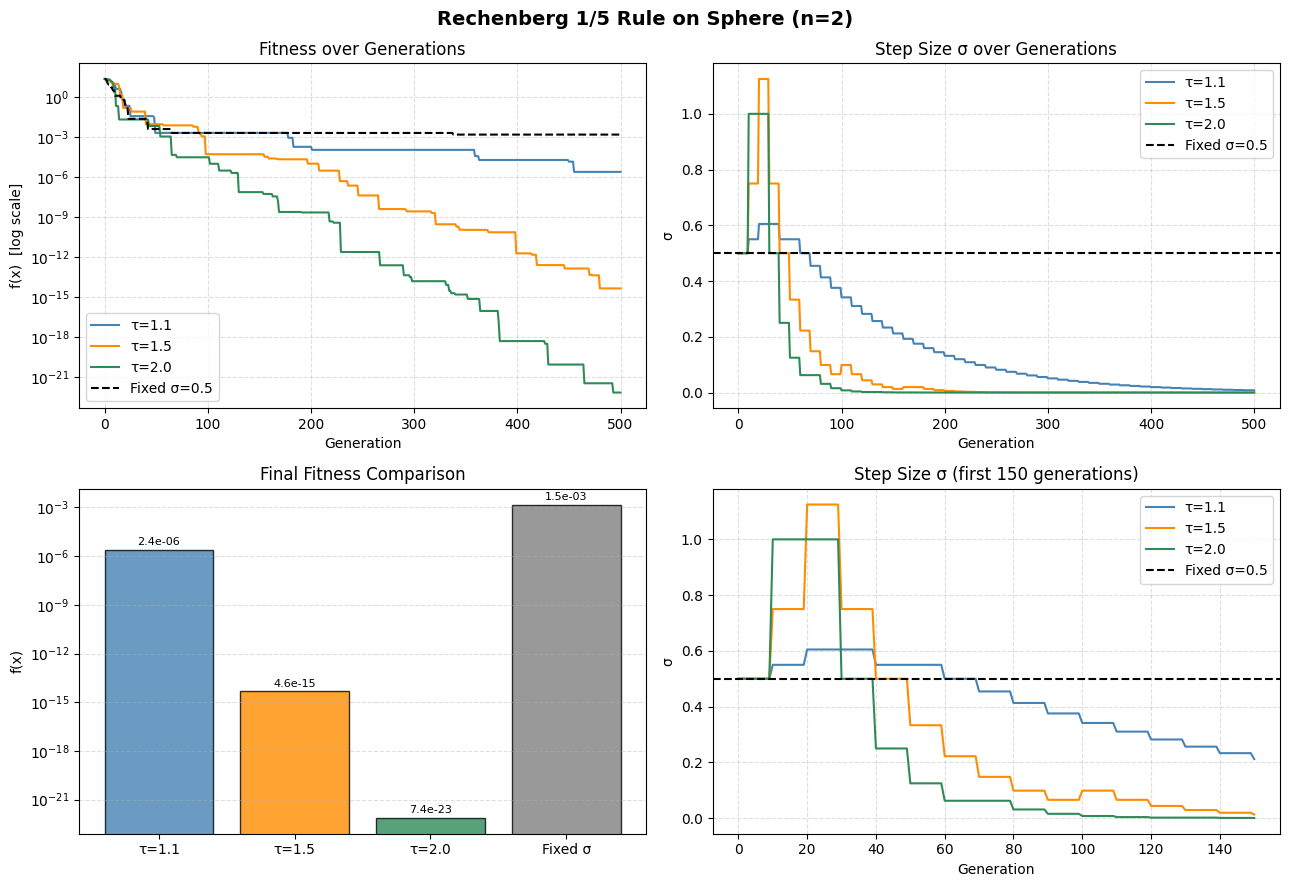

Figure 1 saved.

(b/c) Final fitness values
  τ=1.1   →  2.438578e-06
  τ=1.5   →  4.620489e-15
  τ=2.0   →  7.405236e-23
  Fixed σ →  1.512670e-03


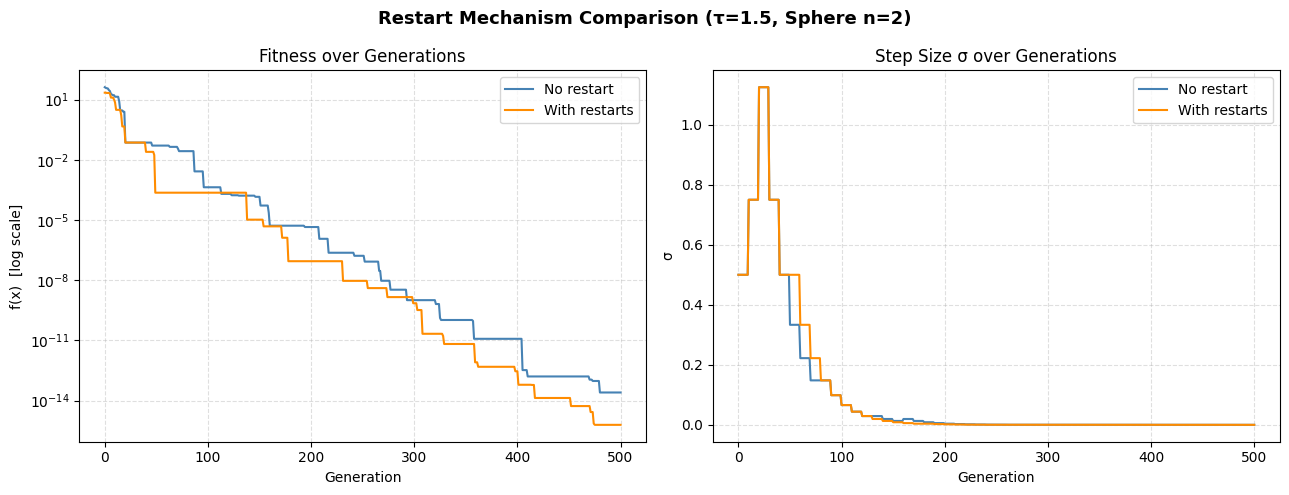

Figure 2 saved.

(d) Restart comparison (τ=1.5)
  No restart   → final fitness: 2.534851e-14
  With restart → final fitness: 6.196567e-16
  Restarts triggered: 0  at generations []


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ─ Benchmark function -
def sphere(x):
    return np.dot(x, x)

# (a) Rechenberg's per-generation update rule
def rechenberg_update(sigma, success_rate, tau, target=0.2):
    """
    Rechenberg's 1/5 success rule:
      success_rate > 1/5  →  step too small  →  increase σ  (multiply by tau)
      success_rate < 1/5  →  step too large  →  decrease σ  (divide by tau)
    tau > 1 is the scale factor; Rechenberg recommends 1.2 – 2.0.
    """
    if success_rate > target:
        return sigma * tau
    elif success_rate < target:
        return sigma / tau
    return sigma

def one_plus_one_es(fitness_fn, N=2, sigma=0.5, max_generations=500,
                    tau=None, k=10, x0=None, fixed_sigma=False):
    """
    (1+1)-ES with optional Rechenberg per-generation step-size control.
    tau=None or fixed_sigma=True → sigma never changes (baseline).
    """
    x = np.random.uniform(-5, 5, N) if x0 is None else x0.copy()
    f = fitness_fn(x)
    success_count = 0
    fitness_history = [f]
    sigma_history   = [sigma]

    for t in range(1, max_generations + 1):
        x_prime = x + sigma * np.random.randn(N)
        f_prime = fitness_fn(x_prime)
        if f_prime <= f:
            x, f = x_prime, f_prime
            success_count += 1
        # per-generation Rechenberg update every k steps
        if (not fixed_sigma) and tau is not None and t % k == 0:
            success_rate  = success_count / k
            sigma         = rechenberg_update(sigma, success_rate, tau)
            sigma         = np.clip(sigma, 1e-10, 10.0)
            success_count = 0
        fitness_history.append(f)
        sigma_history.append(sigma)
    return x, fitness_history, sigma_history

# (b) Compare different τ values on Sphere, n=2
np.random.seed(42)
x0   = np.random.uniform(-5, 5, 2)
GENS = 500
TAUS = [1.1, 1.5, 2.0]

results_tau = {}
for tau in TAUS:
    _, fh, sh = one_plus_one_es(sphere, N=2, sigma=0.5, max_generations=GENS,
                                tau=tau, k=10, x0=x0)
    results_tau[tau] = (fh, sh)
_, fh_fixed, sh_fixed = one_plus_one_es(sphere, N=2, sigma=0.5,
                                         max_generations=GENS, x0=x0,
                                         fixed_sigma=True)

# (c) Plot fitness and σ over time
colors = {1.1: "steelblue", 1.5: "darkorange", 2.0: "seagreen"}
gens   = range(GENS + 1)
fig, axes = plt.subplots(2, 2, figsize=(13, 9))
fig.suptitle("Rechenberg 1/5 Rule on Sphere (n=2)", fontsize=14, fontweight="bold")
# Fitness (log scale)
ax = axes[0, 0]
for tau, (fh, _) in results_tau.items():
    ax.semilogy(gens, fh, label=f"τ={tau}", color=colors[tau])
ax.semilogy(gens, fh_fixed, "k--", label="Fixed σ=0.5")
ax.set_title("Fitness over Generations")
ax.set_xlabel("Generation"); ax.set_ylabel("f(x)  [log scale]")
ax.legend(); ax.grid(True, which="both", linestyle="--", alpha=0.4)
# σ over time
ax = axes[0, 1]
for tau, (_, sh) in results_tau.items():
    ax.plot(gens, sh, label=f"τ={tau}", color=colors[tau])
ax.axhline(0.5, color="k", linestyle="--", label="Fixed σ=0.5")
ax.set_title("Step Size σ over Generations")
ax.set_xlabel("Generation"); ax.set_ylabel("σ")
ax.legend(); ax.grid(True, linestyle="--", alpha=0.4)
# Final fitness bar chart
ax = axes[1, 0]
labels     = [f"τ={t}" for t in TAUS] + ["Fixed σ"]
finals     = [results_tau[t][0][-1] for t in TAUS] + [fh_fixed[-1]]
bar_colors = [colors[t] for t in TAUS] + ["grey"]
bars = ax.bar(labels, finals, color=bar_colors, edgecolor="black", alpha=0.8)
ax.set_title("Final Fitness Comparison"); ax.set_ylabel("f(x)"); ax.set_yscale("log")
for bar, val in zip(bars, finals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.5,
            f"{val:.1e}", ha="center", va="bottom", fontsize=8)
ax.grid(axis="y", linestyle="--", alpha=0.4)
# σ trajectory (zoomed first 150 gens)
ax = axes[1, 1]
for tau, (_, sh) in results_tau.items():
    ax.plot(list(gens)[:151], sh[:151], label=f"τ={tau}", color=colors[tau])
ax.axhline(0.5, color="k", linestyle="--", label="Fixed σ=0.5")
ax.set_title("Step Size σ (first 150 generations)")
ax.set_xlabel("Generation"); ax.set_ylabel("σ")
ax.legend(); ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()
plt.close()
print("Figure 1 saved.")

# Print smmary
print("\n" + "=" * 50)
print("(b/c) Final fitness values")
print("=" * 50)
for tau in TAUS:
    print(f"  τ={tau:<4}  →  {results_tau[tau][0][-1]:.6e}")
print(f"  Fixed σ →  {fh_fixed[-1]:.6e}")

# (d) Restart mechanism
def one_plus_one_es_with_restarts(fitness_fn, N=2, sigma_init=0.5,
                                   max_generations=500, tau=1.5, k=10,
                                   stagnation_window=40, stagnation_tol=1e-14):
    """
    (1+1)-ES with Rechenberg rule + restart when the algorithm is frozen.
    Restart fires only when BOTH conditions hold:
      1. sigma has collapsed below 1e-8  (algorithm can no longer explore)
      2. fitness improvement over the last window < stagnation_tol
    On restart: x is re-sampled uniformly and sigma is reset to sigma_init.
    """
    x     = np.random.uniform(-5, 5, N)
    f     = fitness_fn(x)
    sigma = sigma_init
    success_count = 0

    total_fitness = [f]
    total_sigma   = [sigma]
    restart_gens  = []

    for t in range(1, max_generations + 1):
        x_prime = x + sigma * np.random.randn(N)
        f_prime = fitness_fn(x_prime)
        if f_prime <= f:
            x, f = x_prime, f_prime
            success_count += 1
        if t % k == 0:
            success_rate  = success_count / k
            sigma         = rechenberg_update(sigma, success_rate, tau)
            sigma         = np.clip(sigma, 1e-10, 10.0)
            success_count = 0
        total_fitness.append(f)
        total_sigma.append(sigma)
        # Restart only when sigma has collapsed AND fitness is truly stagnant
        if t >= stagnation_window and sigma <= 1e-8:
            window_improvement = total_fitness[-stagnation_window] - total_fitness[-1]
            if window_improvement < stagnation_tol:
                restart_gens.append(t)
                x     = np.random.uniform(-5, 5, N)
                f     = fitness_fn(x)
                sigma = sigma_init
                success_count = 0
                total_fitness[-1] = f   # overwrite last entry with new start
    return total_fitness, total_sigma, restart_gens

np.random.seed(42)
fh_restart, sh_restart, restarts = one_plus_one_es_with_restarts(
    sphere, N=2, sigma_init=0.5, max_generations=GENS, tau=1.5,
    stagnation_window=40, stagnation_tol=1e-14)
_, fh_no_restart, sh_no_restart = one_plus_one_es(
    sphere, N=2, sigma=0.5, max_generations=GENS, tau=1.5)

# Plot restart comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle("Restart Mechanism Comparison (τ=1.5, Sphere n=2)",
             fontsize=13, fontweight="bold")

gens2 = range(GENS + 1)

ax1.semilogy(gens2, fh_no_restart, label="No restart",     color="steelblue")
ax1.semilogy(gens2, fh_restart,    label="With restarts",  color="darkorange")
for i, r in enumerate(restarts):
    ax1.axvline(r, color="red", linestyle=":", alpha=0.6, linewidth=0.8,
                label="Restart" if i == 0 else None)
ax1.set_title("Fitness over Generations"); ax1.set_xlabel("Generation")
ax1.set_ylabel("f(x)  [log scale]")
ax1.legend(); ax1.grid(True, which="both", linestyle="--", alpha=0.4)

ax2.plot(gens2, sh_no_restart, label="No restart",    color="steelblue")
ax2.plot(gens2, sh_restart,    label="With restarts", color="darkorange")
for i, r in enumerate(restarts):
    ax2.axvline(r, color="red", linestyle=":", alpha=0.6, linewidth=0.8,
                label="Restart" if i == 0 else None)
ax2.set_title("Step Size σ over Generations"); ax2.set_xlabel("Generation")
ax2.set_ylabel("σ"); ax2.legend()
ax2.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()
plt.close()
print("Figure 2 saved.")

print("\n" + "=" * 50)
print("(d) Restart comparison (τ=1.5)")
print("=" * 50)
print(f"  No restart   → final fitness: {fh_no_restart[-1]:.6e}")
print(f"  With restart → final fitness: {fh_restart[-1]:.6e}")
print(f"  Restarts triggered: {len(restarts)}  at generations {restarts}")